# patch_size를 1, 3, 5, 7, 9, 11로 바꾸어 가면서 테스트 해 보자

In [1]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.video_classifier import TransformerModel
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
val_filter = lambda x: x >= 1 and (x % 50) in {1, 6, 13, 18, 25, 30, 32, 37, 44, 49}

1
train data


Evaluation Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3796/3796 [00:26<00:00, 140.97it/s]


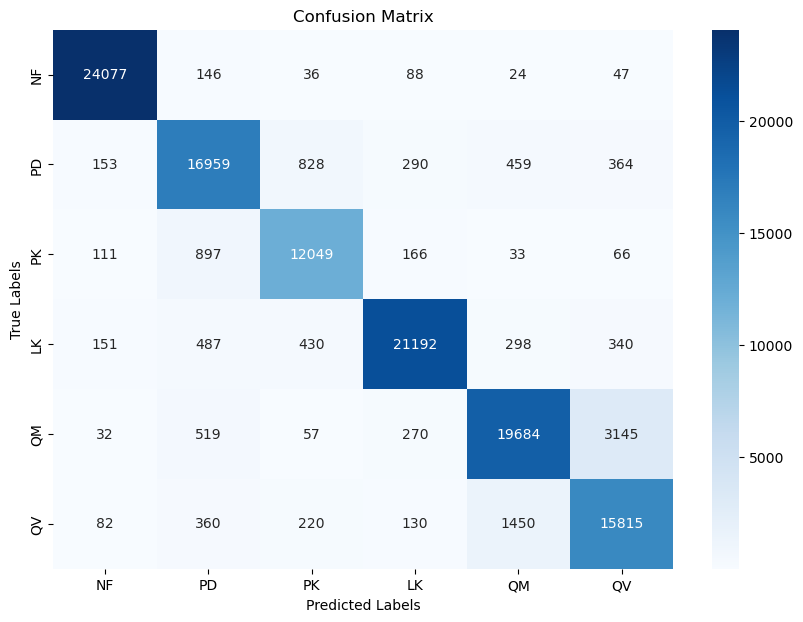

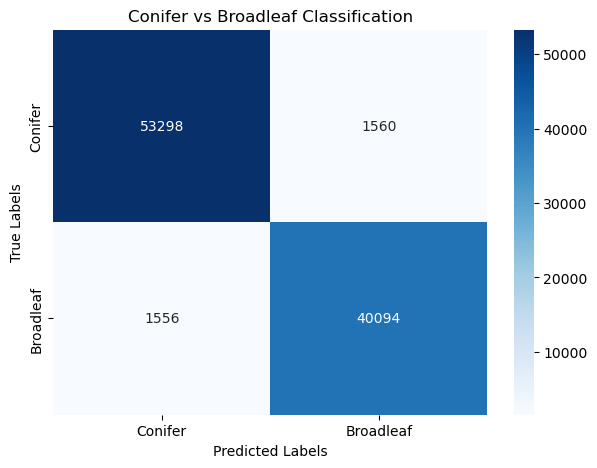

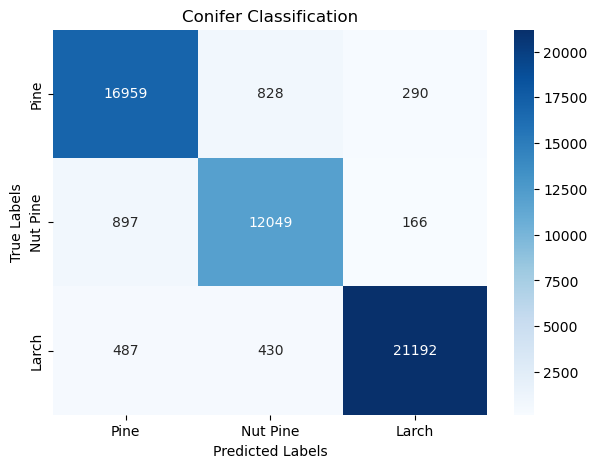

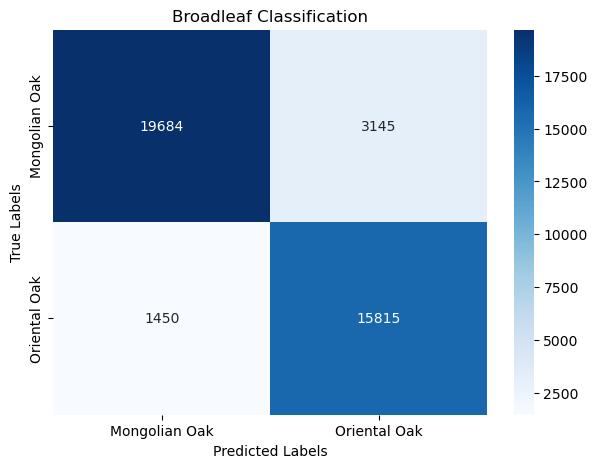

validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 940/940 [00:06<00:00, 144.18it/s]


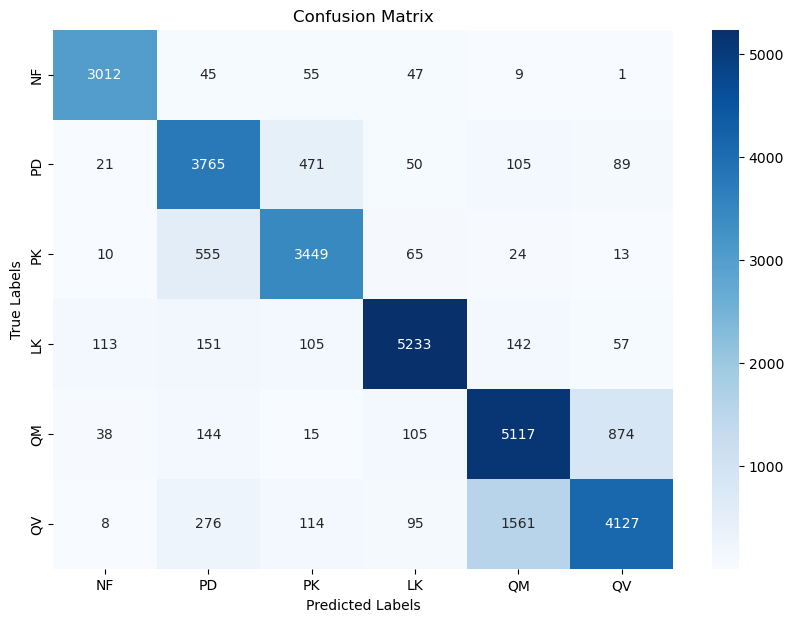

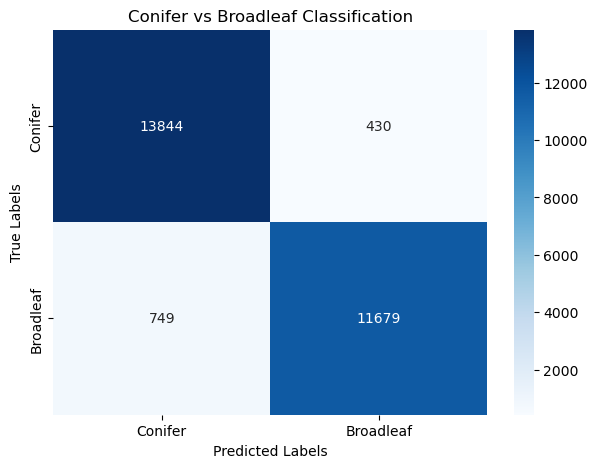

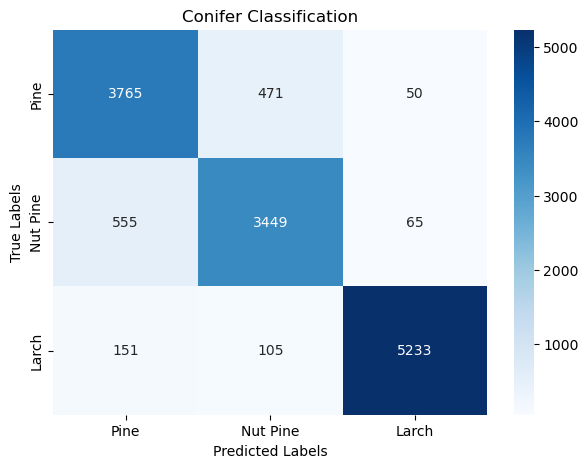

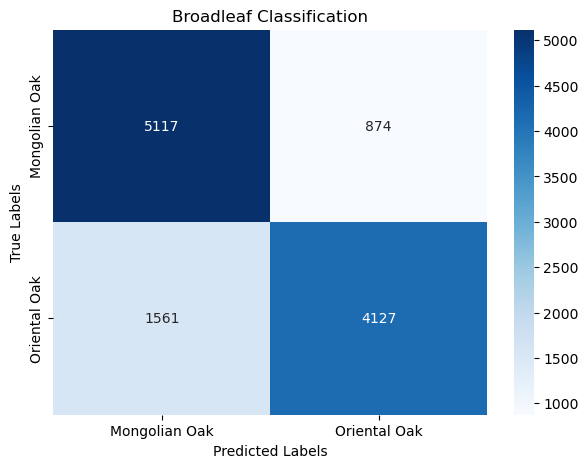

3
train data


Evaluation Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3796/3796 [00:29<00:00, 130.66it/s]


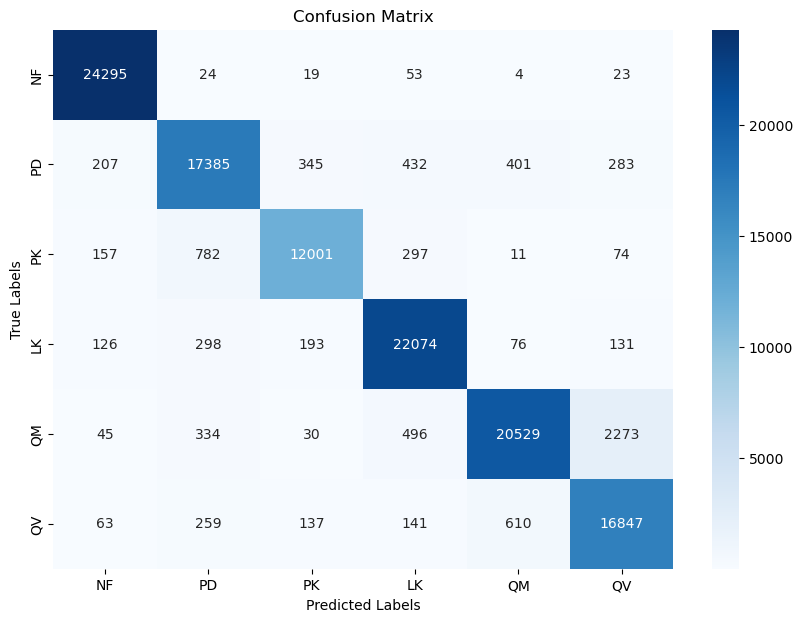

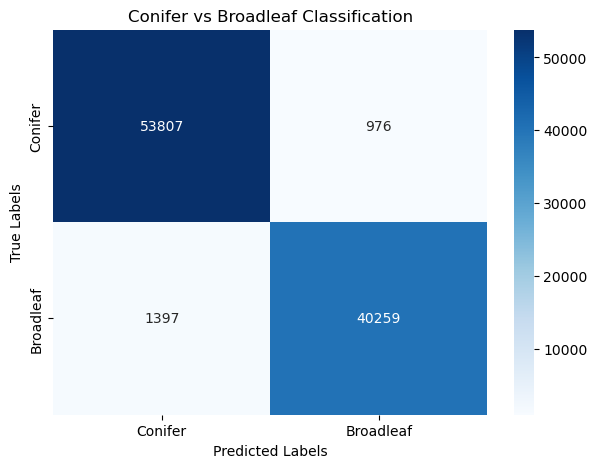

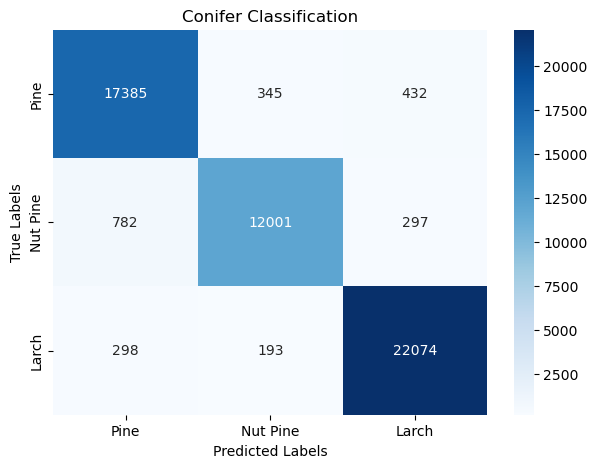

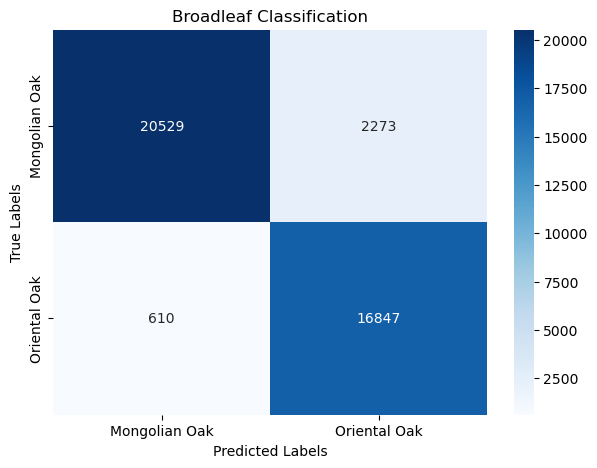

validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 940/940 [00:07<00:00, 130.17it/s]


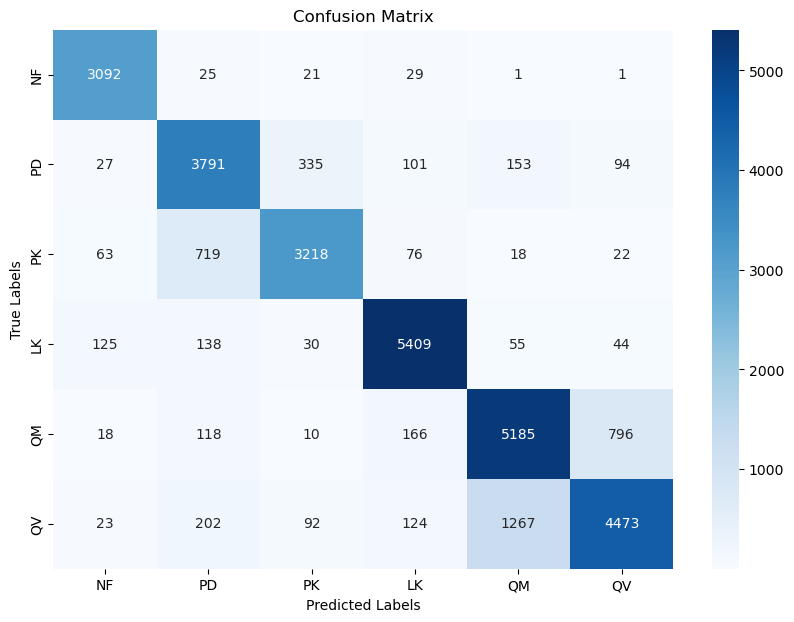

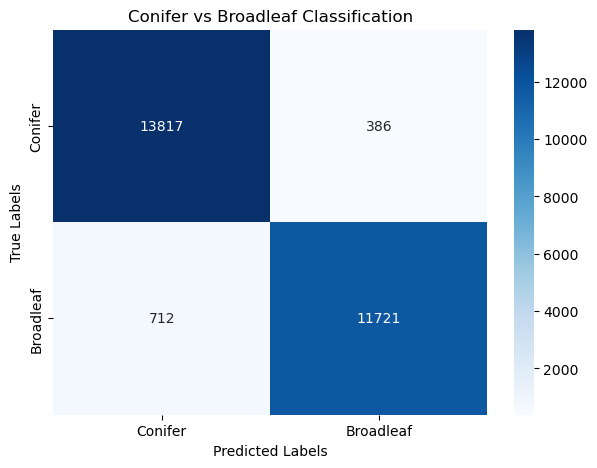

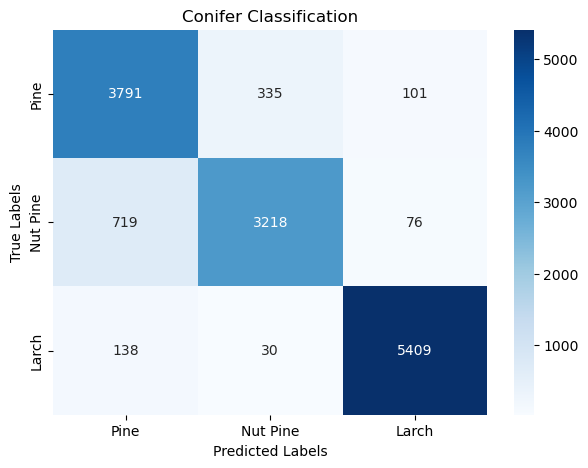

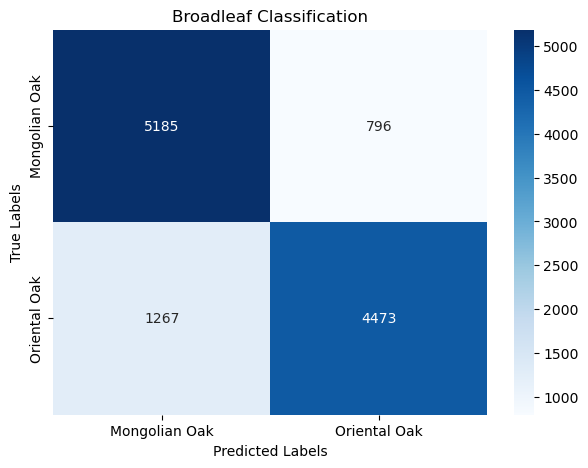

5
train data


Evaluation Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3773/3773 [00:30<00:00, 124.13it/s]


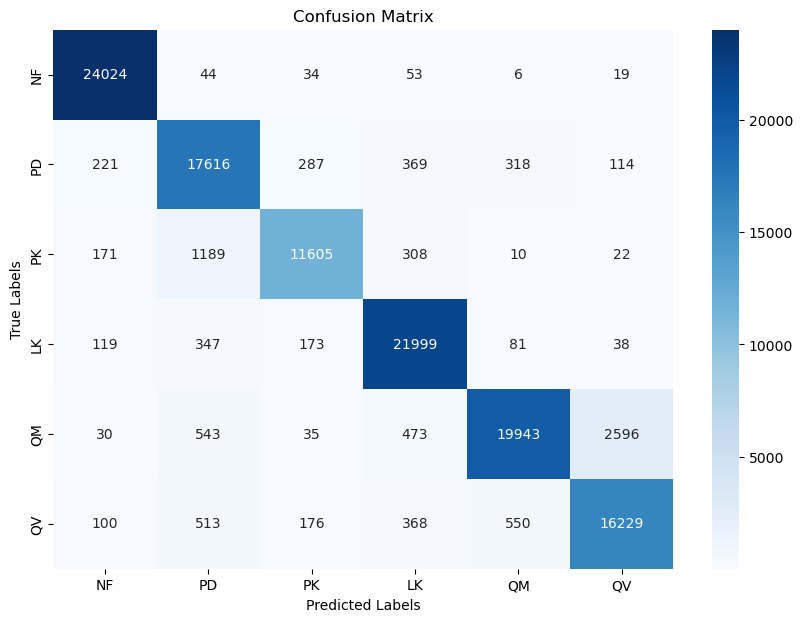

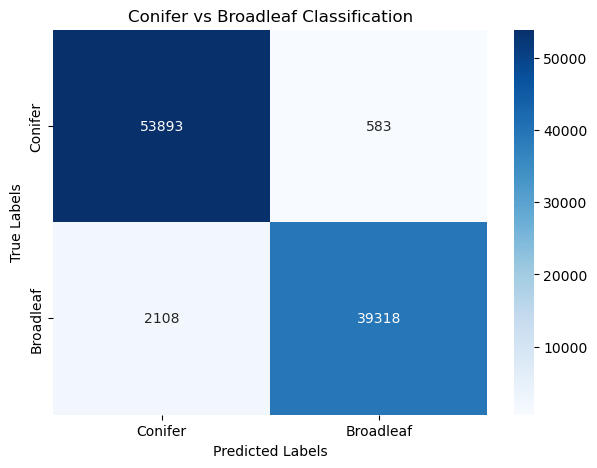

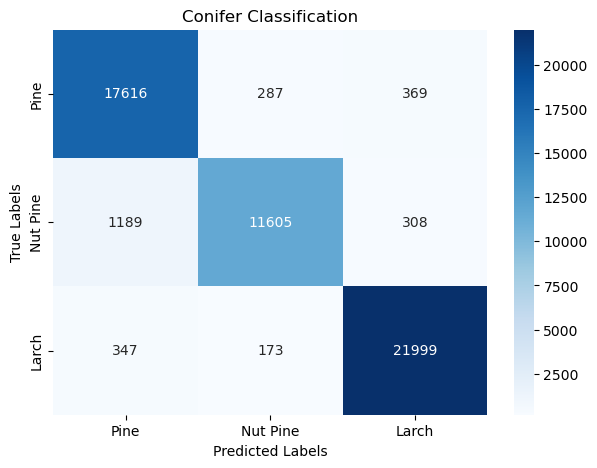

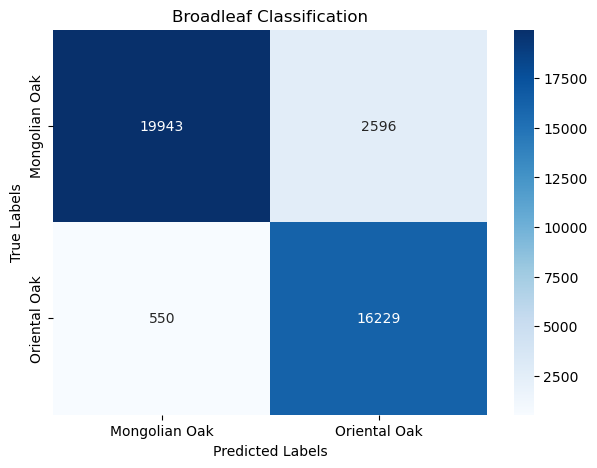

validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [00:07<00:00, 125.52it/s]


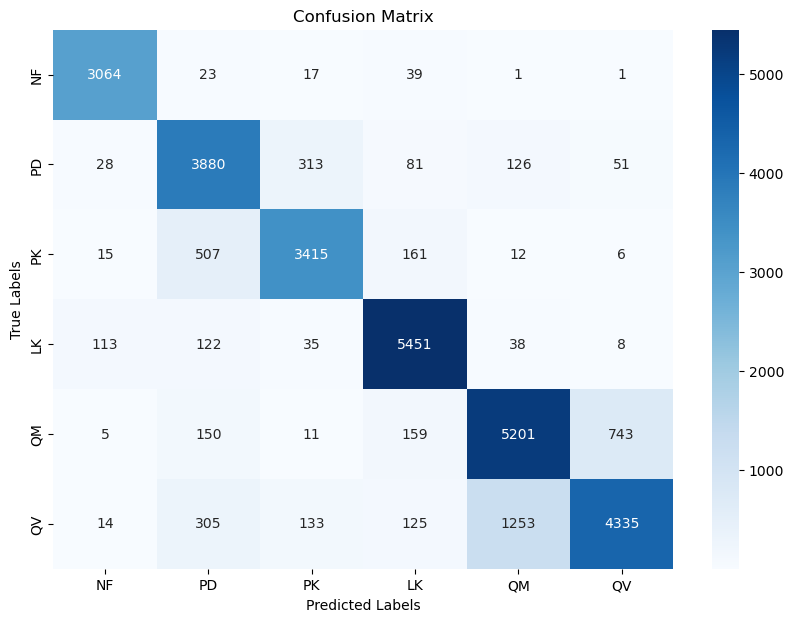

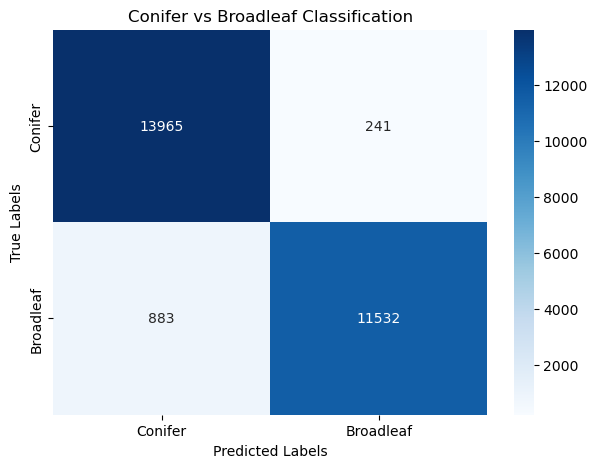

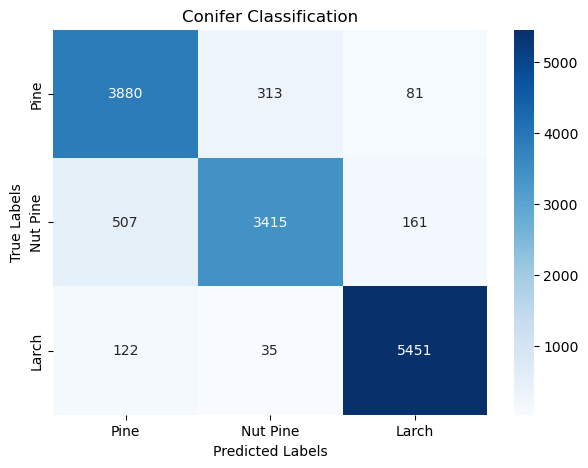

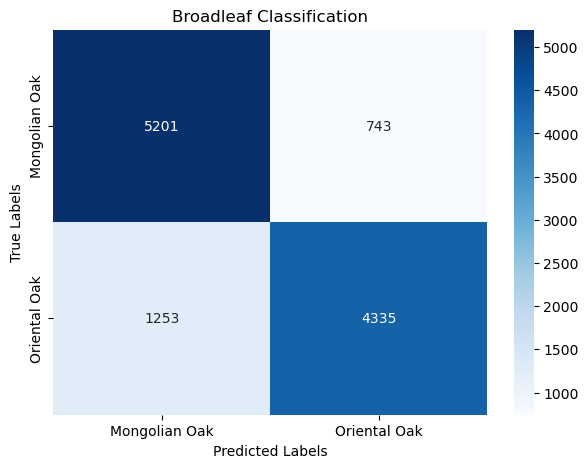

7
train data


Evaluation Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3773/3773 [00:30<00:00, 121.97it/s]


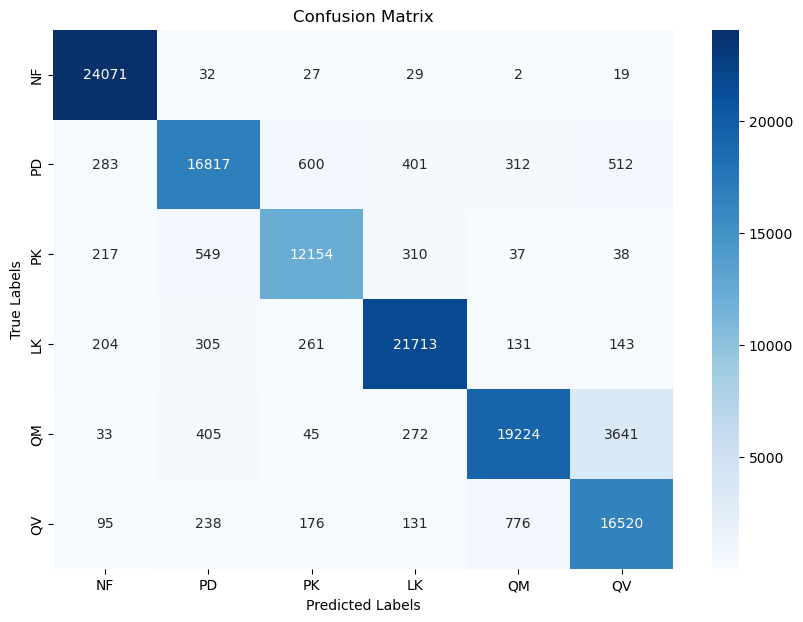

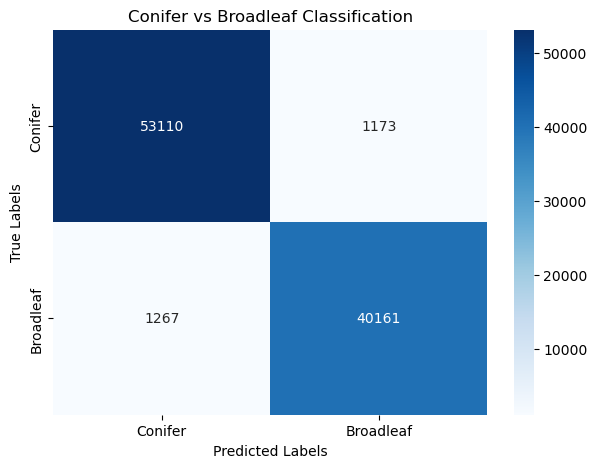

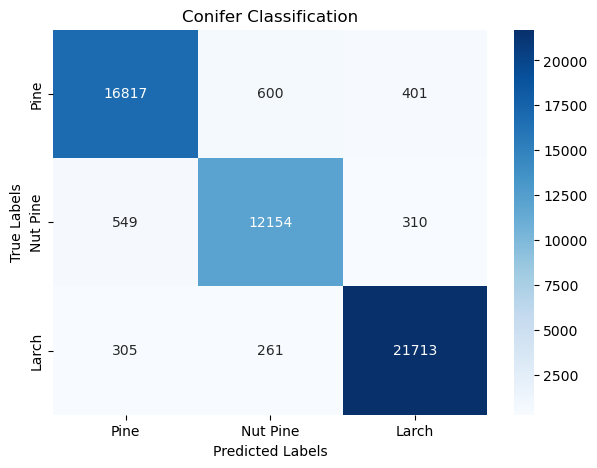

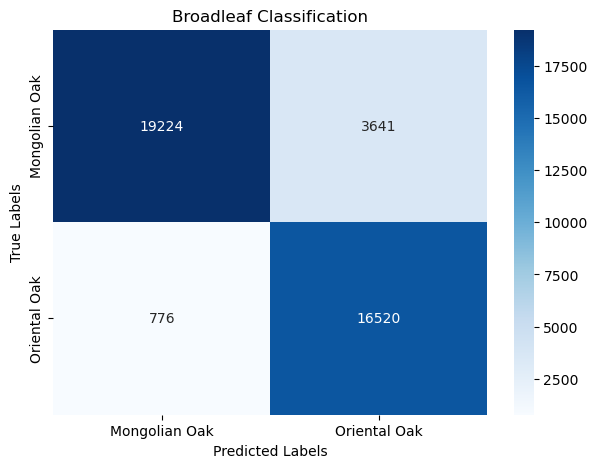

validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [00:07<00:00, 122.35it/s]


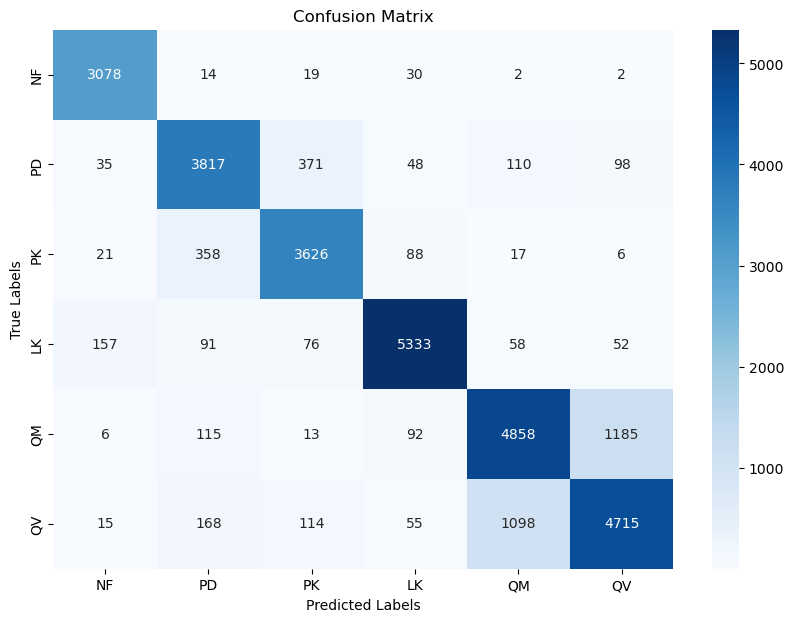

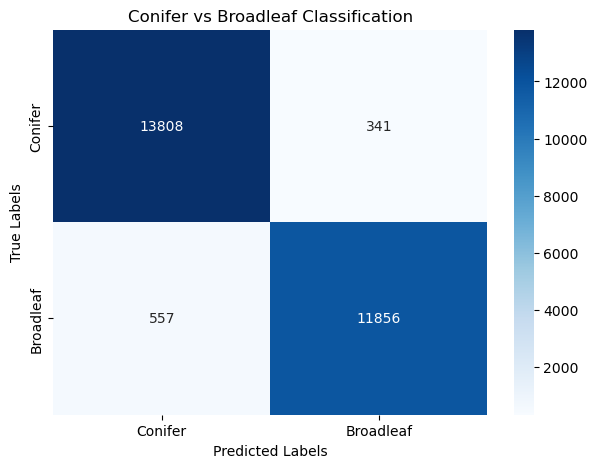

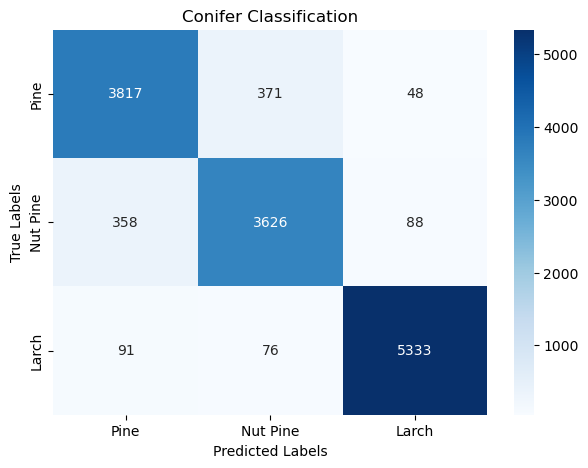

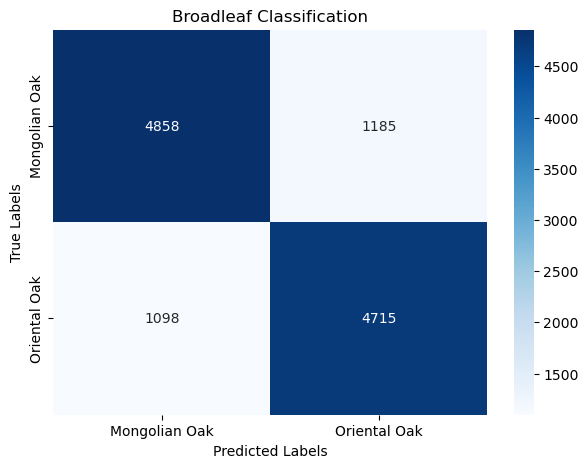

9
train data


Evaluation Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3773/3773 [00:31<00:00, 119.00it/s]


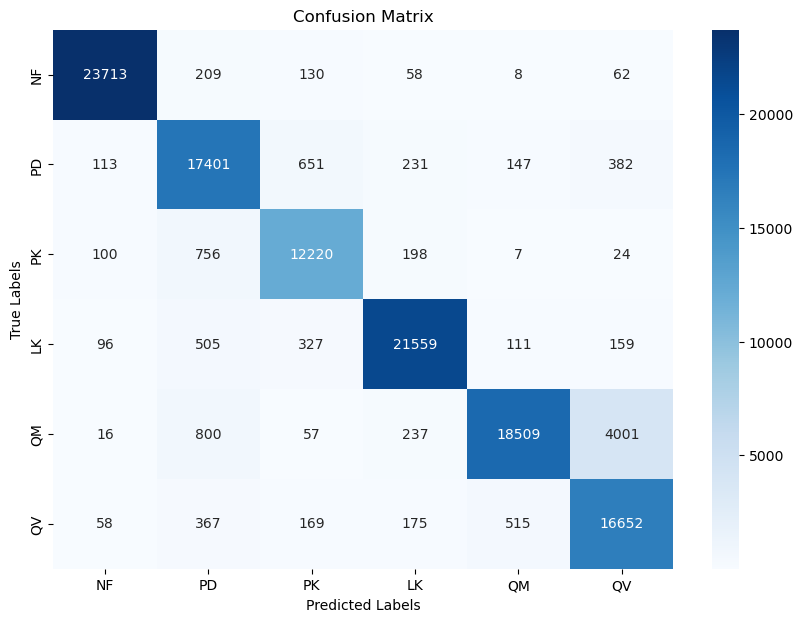

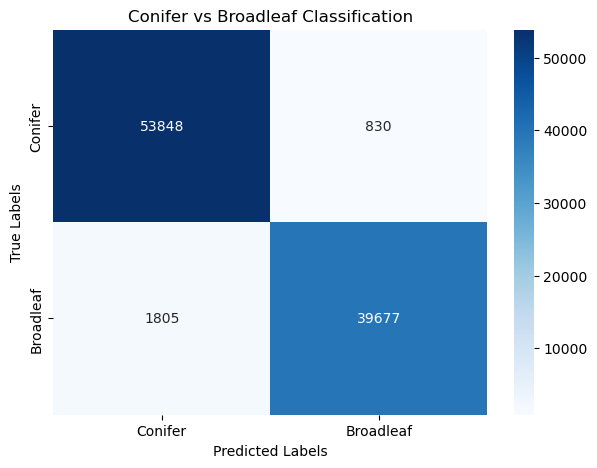

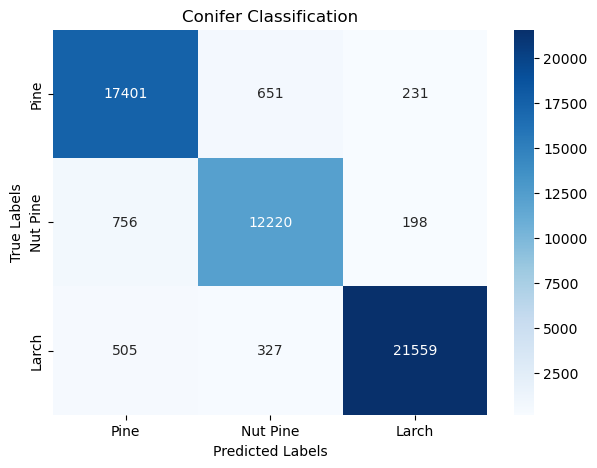

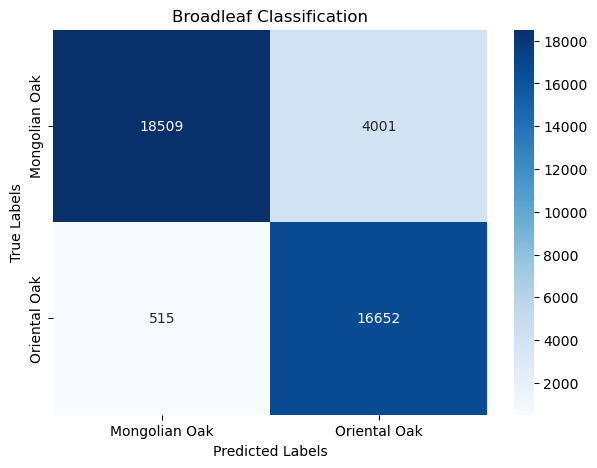

validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [00:07<00:00, 118.87it/s]


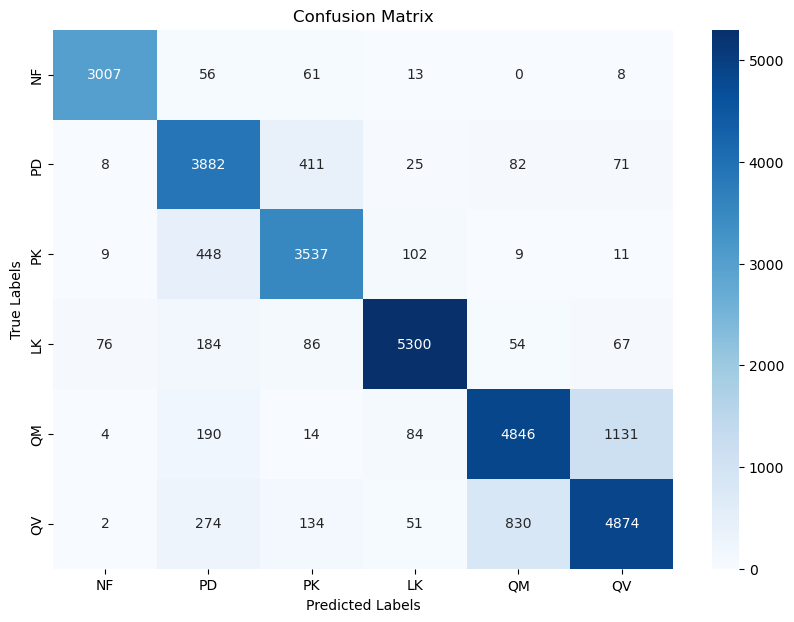

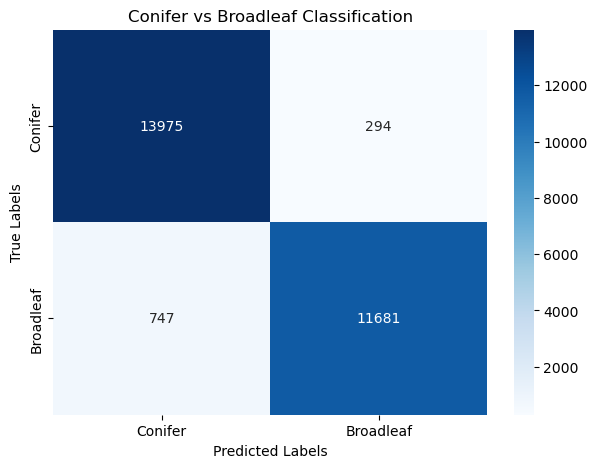

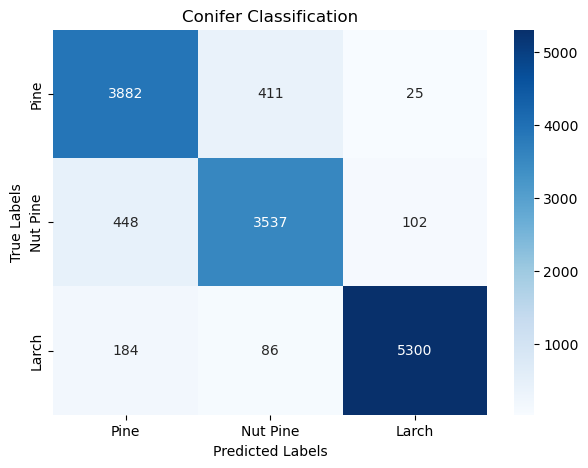

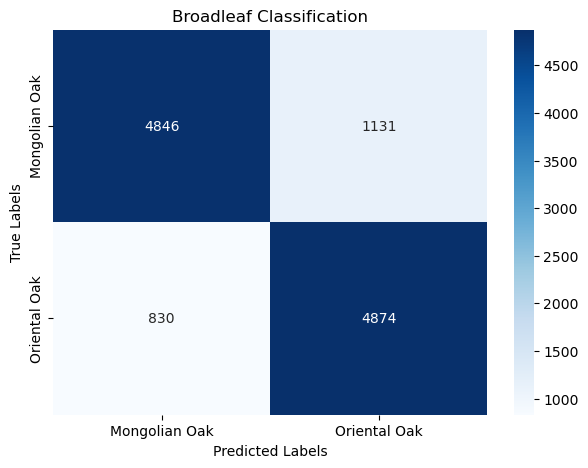

11
train data


Evaluation Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:33<00:00, 113.02it/s]


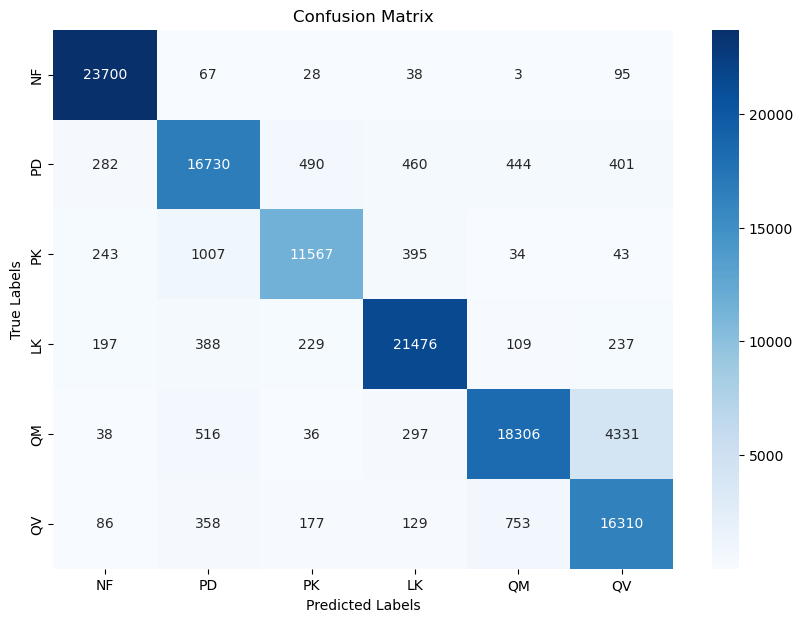

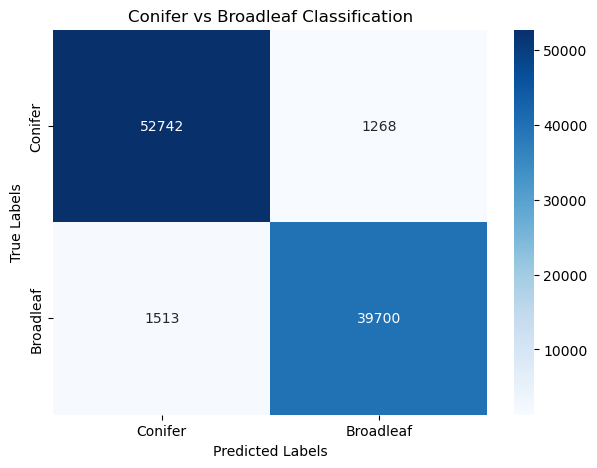

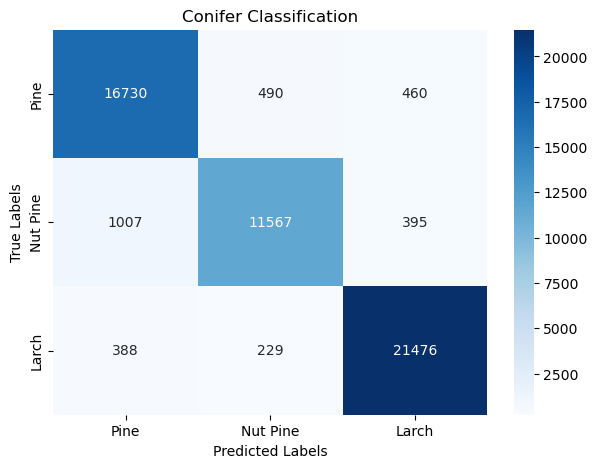

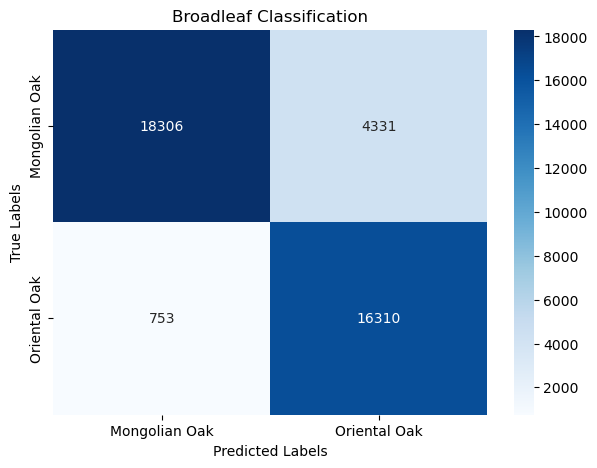

validation data


Evaluation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 933/933 [00:08<00:00, 113.53it/s]


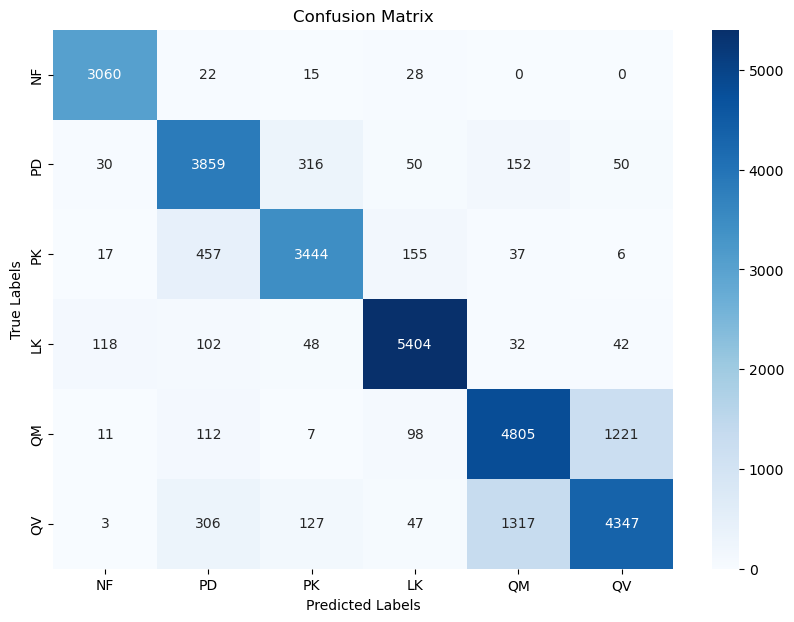

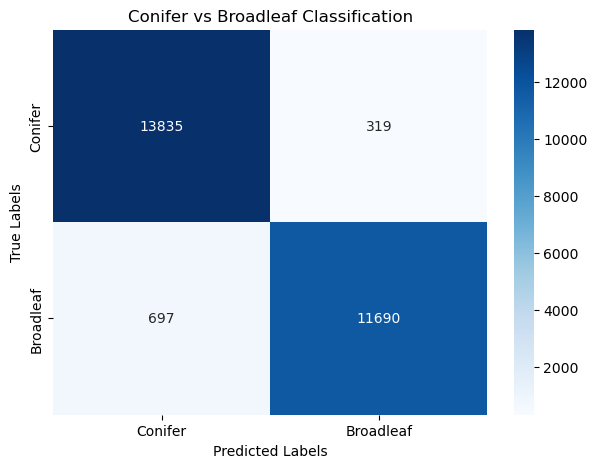

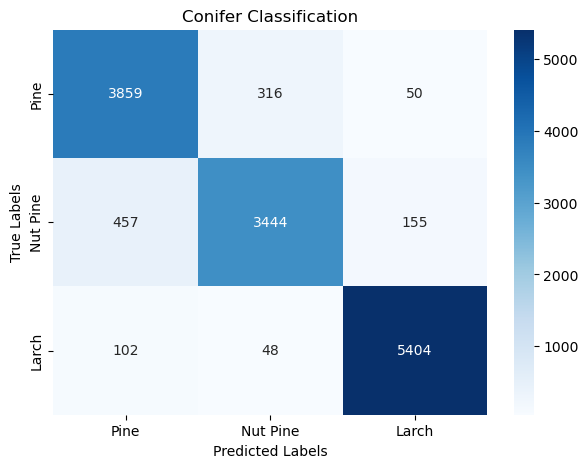

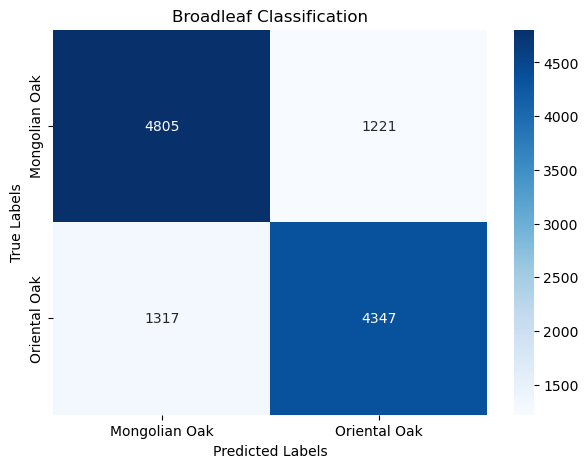

In [7]:
bands = 4
num_epochs = 100
patch_sizes = [1, 3, 5, 7, 9, 11]
result_df_dicts = {"patch_size": [],
                   "data_type" : [],
                   "df" : []}
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir
large_tif_dir = '../../data/source_data/naive' #원천데이터 주소

class ReshapeTransform:
    """(12*bands, 3, 3) → (12, bands, 3, 3) 변환"""
    def __init__(self, bands, patch_size):
        self.bands = bands
        self.patch_size = patch_size
    def __call__(self, x):
        p
        return x.view(12, self.bands, self.patch_size, self.patch_size).permute(1, 0, 2, 3)

def get_transform(bands, patch_size, scale_channels_func=None):
    transform_list = [
        transforms.ToTensor(),  # (H, W, C) → (C, H, W)
        transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
        ReshapeTransform(bands, patch_size)  # (12*bands, 3, 3) → (bands, 12, 3, 3)
    ]

    if scale_channels_func:
        transform_list.append(transforms.Lambda(scale_channels_func))  # 채널별 값 조정 추가

    return transforms.Compose(transform_list)

#scaling 함수 - 채널별로 범위의 차이가 크기때문에 어느정도 맞추어주기 위해서 수행
def scale_channels(x):
    """특정 채널값 조정"""
    x[0:3] *= 5  # B,G,R 채널 * 5
    if 4 < x.shape[0]:
        x[4] *= 0.5  # NDVI 채널 * 0.5
    return x

for patch_size in patch_sizes:
    
    print(patch_size)
    transform = get_transform(bands, patch_size, scale_channels)
    
    train_dataset = TiffDataset(
                large_tif_dir = large_tif_dir,
                file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
                label_file = "../../data/label_data/species/label_mapping_sampled.csv",
                box_filter_fn = lambda box_number: not val_filter(box_number),
                patch_size = patch_size,
                transform=transform
            )

    val_dataset = TiffDataset(
                large_tif_dir = large_tif_dir,
                file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
                label_file ="../../data/label_data/species/label_mapping_sampled.csv",
                box_filter_fn = val_filter,
                patch_size = patch_size,
                transform=transform
            )

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    d_model = 8*(patch_size+7)
    model = TransformerModel(patch_size=patch_size, d_model=d_model).to(device)
    model.load_state_dict(torch.load(f"./checkpoints/patch_size_test/transformer_new_{bands}_{patch_size}_{num_epochs}.pth"))

    print("train data")
    train_df = evaluate_model_with_cm(model, train_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("train_data")
    result_df_dicts["df"].append(train_df)

    print("validation data")
    validation_df = evaluate_model_with_cm(model, val_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("validation")
    result_df_dicts["df"].append(validation_df)

    # ✅ 메모리 정리
    del model, train_loader, val_loader
    torch.cuda.empty_cache()

In [8]:
# 모든 데이터를 하나의 데이터프레임으로 합치기
final_df = pd.concat([
    df.assign(patch_size=patch, data_type=dt)
    for patch, dt, df in zip(result_df_dicts["patch_size"], result_df_dicts["data_type"], result_df_dicts["df"])
], ignore_index=False)

# 인덱스를 리셋하고 정리
final_df.reset_index(inplace=True)
final_df.rename(columns={"index": "class"}, inplace=True)

# 저장
os.makedirs("./results", exist_ok=True) 
final_df.to_csv("./results/patch_size_transformer_new_results.csv", index=False, encoding="utf-8-sig")

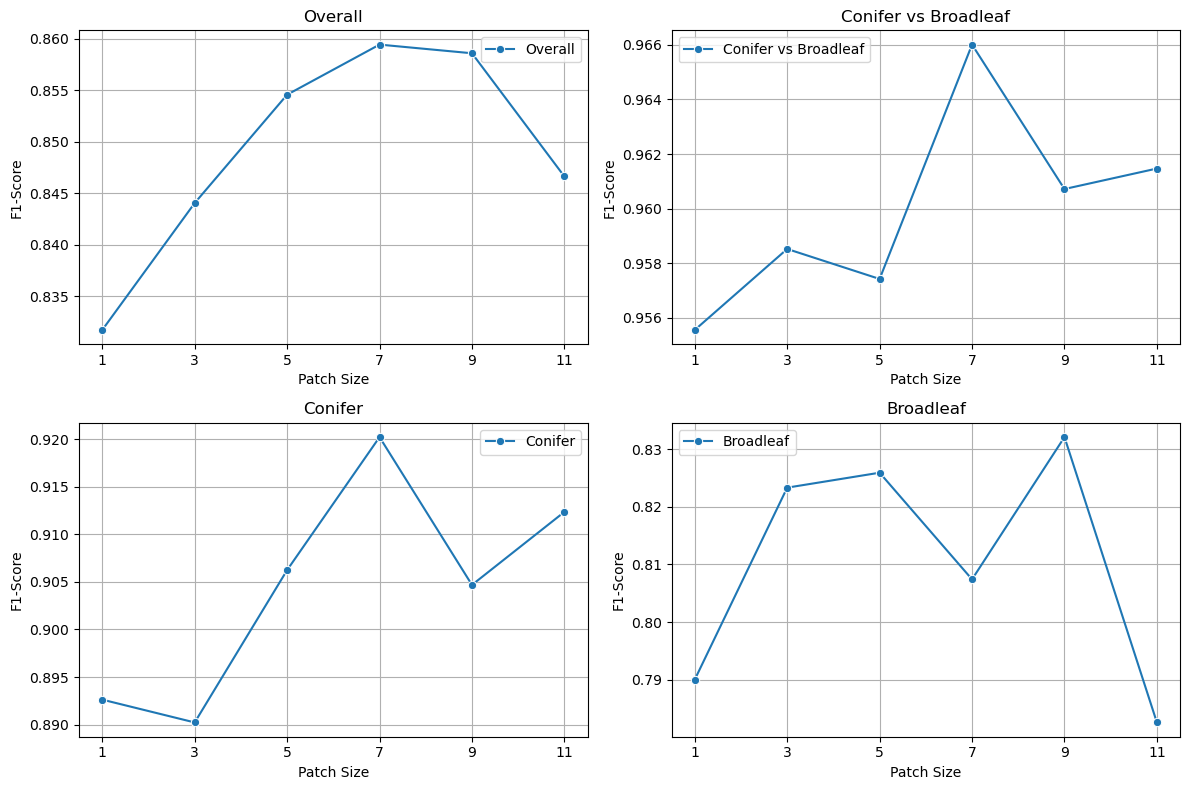

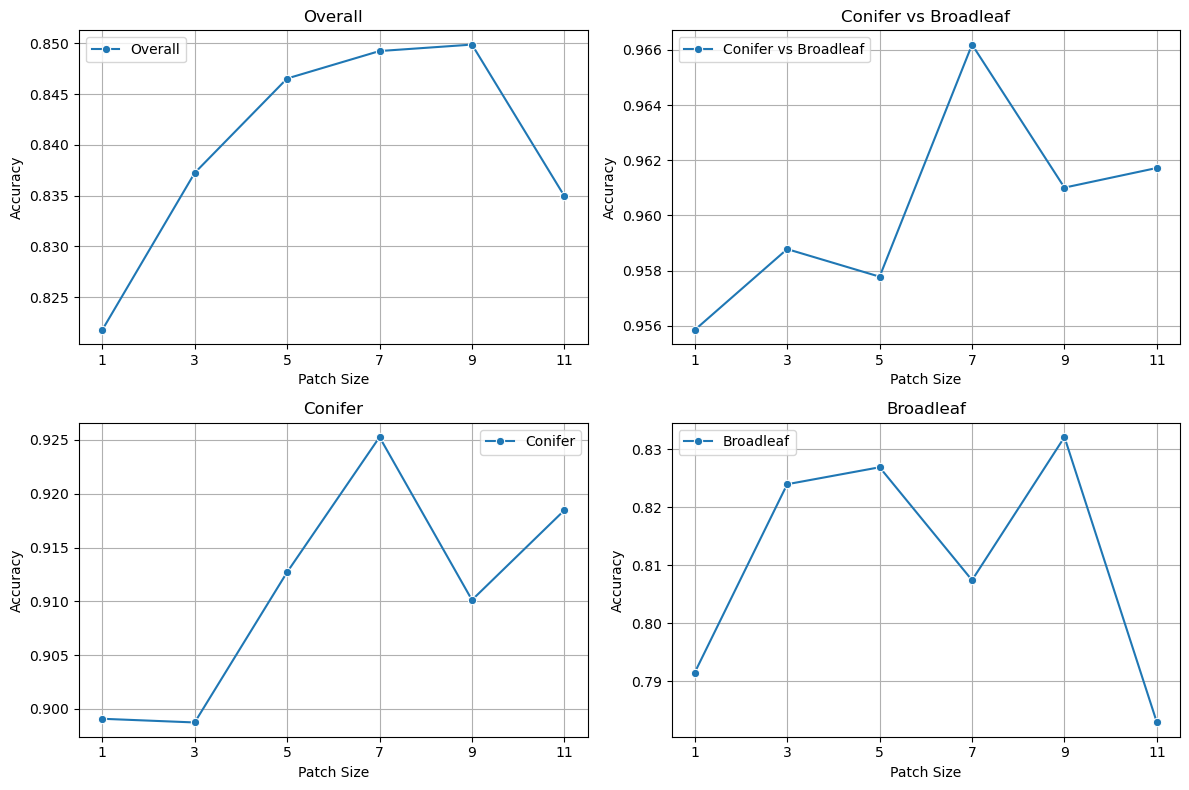

In [9]:
# 데이터 로드
df = pd.read_csv("./results/patch_size_transformer_new_results.csv")

# macro avg이면서 validation 데이터만 필터링
filtered_df = df[(df['class'] == 'macro avg') & (df['data_type'] == 'validation')]

# 카테고리별 데이터 분할
categories = filtered_df['Category'].unique()

# 시각화
plt.figure(figsize=(12, 8))

for i, category in enumerate(categories, 1):
    plt.subplot(2, 2, i)
    
    # 특정 카테고리 데이터 선택
    cat_df = filtered_df[filtered_df['Category'] == category]
    
    # 그래프 그리기 (patch_size별 f1-score 그대로 사용)
    sns.lineplot(x=cat_df['patch_size'], y=cat_df['f1-score'], marker='o', label=category)
    
    plt.title(category)
    plt.xlabel('Patch Size')
    plt.ylabel('F1-Score')
    plt.xticks(sorted(cat_df['patch_size'].unique()))  # X축 정렬
    plt.grid(True)

plt.tight_layout()
plt.show()



# macro avg이면서 validation 데이터만 필터링
filtered_df = df[(df['class'] == 'accuracy') & (df['data_type'] == 'validation')]

# 카테고리별 데이터 분할
categories = filtered_df['Category'].unique()

# 시각화
plt.figure(figsize=(12, 8))

for i, category in enumerate(categories, 1):
    plt.subplot(2, 2, i)
    
    # 특정 카테고리 데이터 선택
    cat_df = filtered_df[filtered_df['Category'] == category]
    
    # 그래프 그리기 (patch_size별 f1-score 그대로 사용)
    sns.lineplot(x=cat_df['patch_size'], y=cat_df['f1-score'], marker='o', label=category)
    
    plt.title(category)
    plt.xlabel('Patch Size')
    plt.ylabel('Accuracy')
    plt.xticks(sorted(cat_df['patch_size'].unique()))  # X축 정렬
    plt.grid(True)

plt.tight_layout()
plt.show()

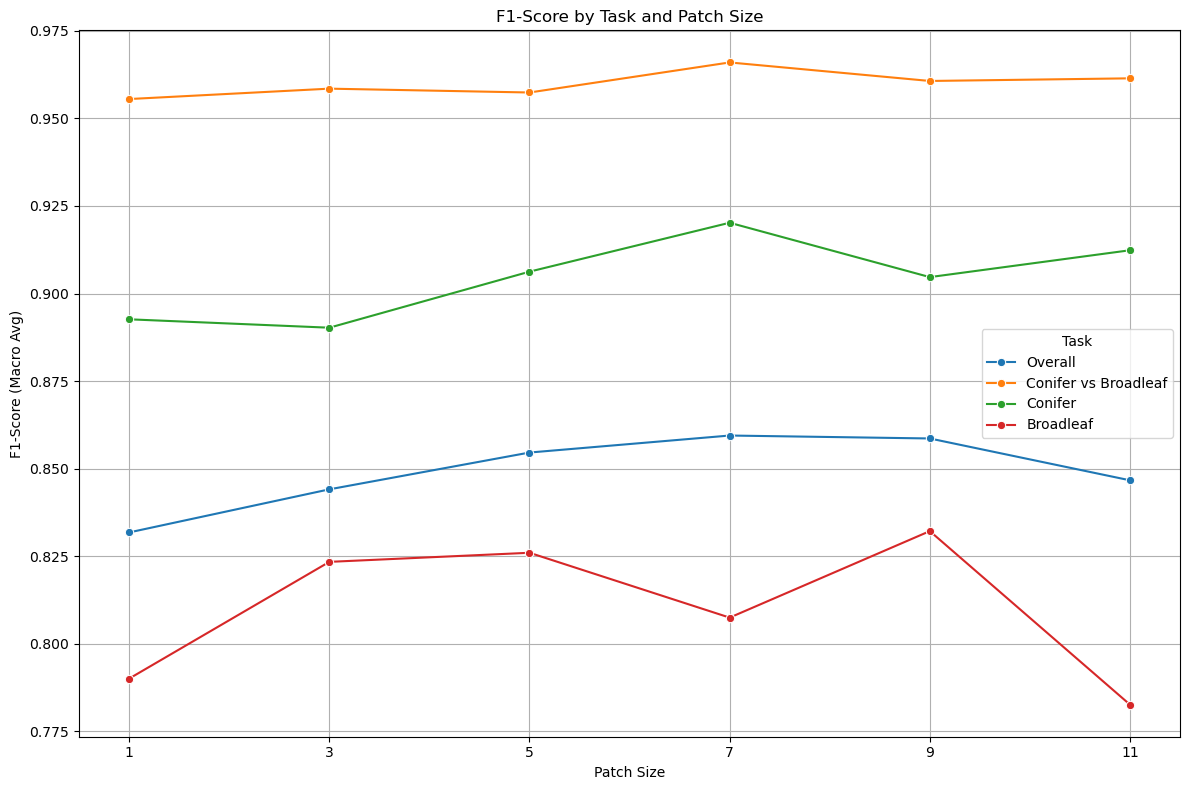

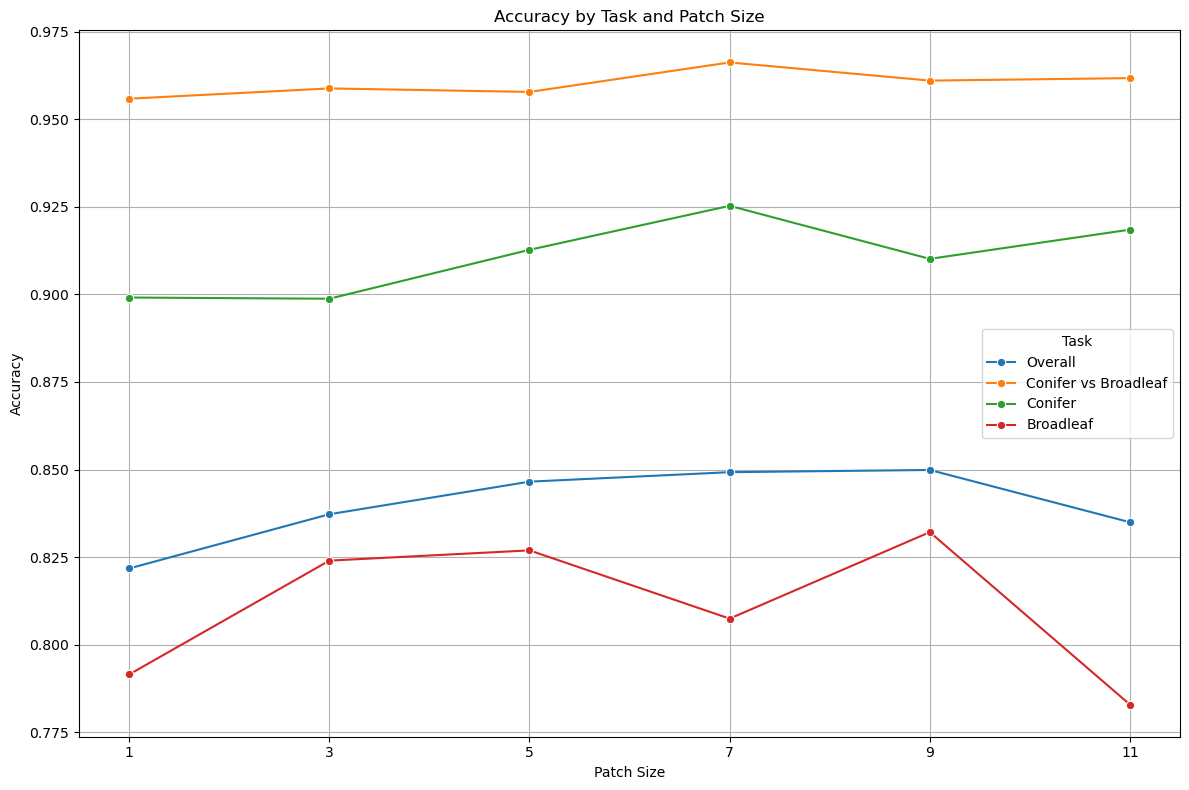

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# macro avg이면서 validation 데이터만 필터링
filtered_df = df[(df['class'] == 'macro avg') & (df['data_type'] == 'validation')]

# 시각화
plt.figure(figsize=(12, 8))

# 모든 카테고리를 하나의 그래프에 표시
for category in filtered_df['Category'].unique():
    cat_df = filtered_df[filtered_df['Category'] == category]
    sns.lineplot(x='patch_size', y='f1-score', data=cat_df, marker='o', label=category)

plt.title('F1-Score by Task and Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('F1-Score (Macro Avg)')
plt.xticks(sorted(filtered_df['patch_size'].unique()))  # X축 정렬
plt.legend(title='Task')
plt.grid(True)

plt.tight_layout()
plt.show()

# Accuracy 그래프
filtered_df_acc = df[(df['class'] == 'accuracy') & (df['data_type'] == 'validation')]

plt.figure(figsize=(12, 8))

for category in filtered_df_acc['Category'].unique():
    cat_df = filtered_df_acc[filtered_df_acc['Category'] == category]
    sns.lineplot(x='patch_size', y='f1-score', data=cat_df, marker='o', label=category)

plt.title('Accuracy by Task and Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Accuracy')
plt.xticks(sorted(filtered_df_acc['patch_size'].unique()))  # X축 정렬
plt.legend(title='Task')
plt.grid(True)

plt.tight_layout()
plt.show()

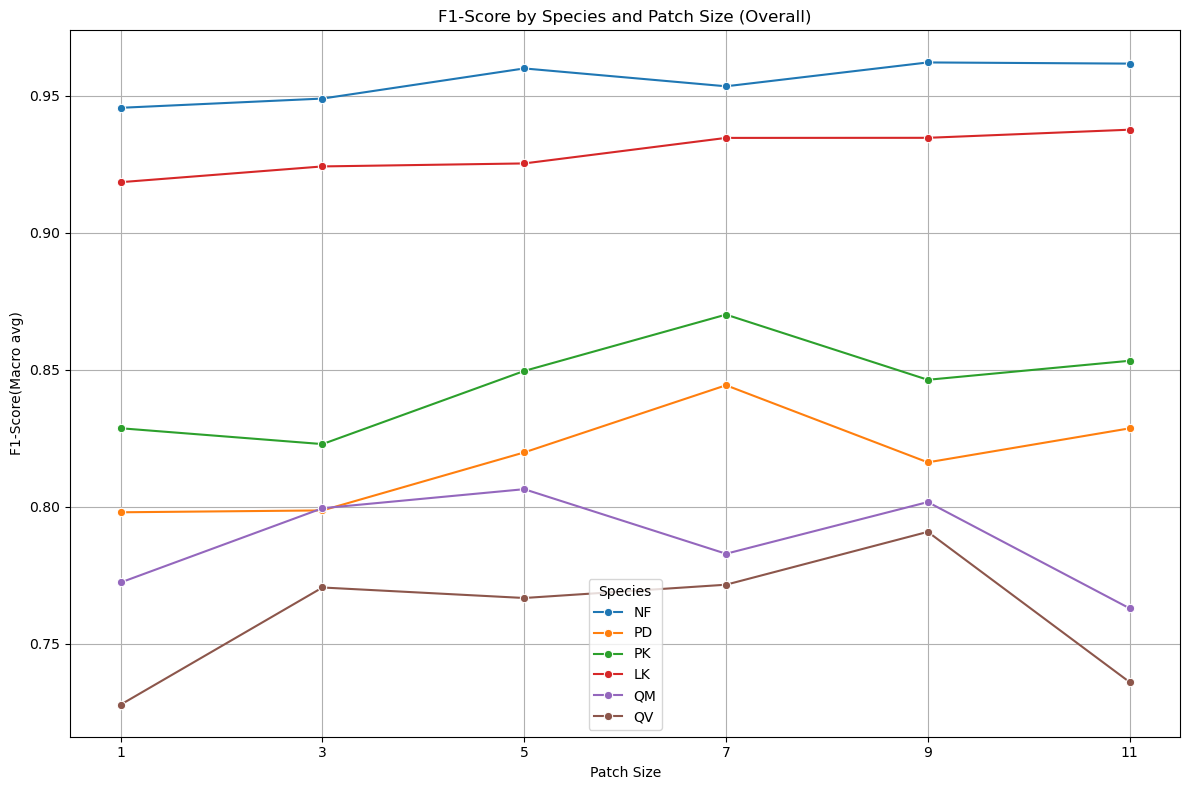

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Overall 카테고리와 validation 데이터만 필터링
filtered_df = df[(df['Category'] == 'Overall') & (df['data_type'] == 'validation')]

# 수종별 데이터 분할
species = ['NF', 'PD', 'PK', 'LK', 'QM', 'QV']

# 시각화
plt.figure(figsize=(12, 8))

for species_name in species:
    species_df = filtered_df[filtered_df['class'] == species_name]
    sns.lineplot(x='patch_size', y='f1-score', data=species_df, marker='o', label=species_name)

plt.title('F1-Score by Species and Patch Size (Overall)')
plt.xlabel('Patch Size')
plt.ylabel('F1-Score(Macro avg)')
plt.xticks([1, 3, 5, 7, 9, 11])
plt.legend(title='Species')
plt.grid(True)

plt.tight_layout()
plt.show()
